## Aspergillus

This analysis solely focuses on the presence of Apergillus. Initially we will look at pwCF ID 676138 because they have Aspergillus infections, and then we expand to all people. There is a summary write up available too.

## Import the libraries

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


In [2]:
sequence_type = "MGI"
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "species"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=True)

merged = df.join(metadata, how='inner')

print(f"The merged Data Frame has shape: {merged.shape}")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Read 127 samples and 769 subsystems


The merged Data Frame has shape: (127, 32306)


Read 127 samples and 31371 species
Read 127 samples and 166 metadata columns


## Inititally focus on one pwCF who has Aspergillus.

In [3]:
aspergs = []
for c in merged.columns:
    if 'aspergill' in c.lower(): 
        aspergs.append(c)

igs = ['IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'FEV1/best FEV1']
res = merged[merged['pwCF_ID']==676138].loc[:,['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + aspergs].sort_values(by='Sample date')
res

,pwCF_ID,Sample date,Sum of antifungals,IgE,Spec IgE,Spec IgG,Precipitins,FEV1/best FEV1,Aspergillus aculeatinus,Aspergillus alliaceus,...,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus,P12M_6_Aspergillus,N12M_Aspergillus fumigatus,O_Aspergillus Flavus,O_Aspergillus niger,O_Aspergillus terreus
676138_20171001_S,676138,2017-10-01,0,NaN,NaN,NaN,NaN,0.964286,0.0,0.0,...,0,0,0,0,0,1.0,1.0,0,0,0
676138_20171009_S,676138,2017-10-09,0,NaN,NaN,NaN,NaN,0.964286,0.0,0.0,...,1,0,0,0,0,1.0,1.0,0,0,0
676138_20180130_S,676138,2018-01-30,2,NaN,NaN,NaN,NaN,0.928571,0.0,0.0,...,0,0,0,0,0,1.0,1.0,0,0,0
676138_20180323_S,676138,2018-03-23,1,992.0,36.0,NaN,2.0,0.857143,0.0,0.0,...,1,0,0,0,0,1.0,1.0,0,0,0
676138_20180405_S,676138,2018-04-05,2,NaN,NaN,NaN,NaN,0.892857,0.0,0.0,...,0,0,0,0,0,1.0,1.0,0,0,0


In [4]:
todrop = []
for c in df.columns:
    if 'aspergill' in c.lower() and res[c].sum() == 0:
        todrop.append(c)
res = res.drop(todrop, axis=1)

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res)

,pwCF_ID,Sample date,Sum of antifungals,IgE,Spec IgE,Spec IgG,Precipitins,FEV1/best FEV1,Aspergillus candidus,Aspergillus fischeri,Aspergillus fumigatus,Aspergillus mulundensis,Aspergillus sclerotialis,Aspergillus turcosus,Aspergillus udagawae,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus,P12M_6_Aspergillus,N12M_Aspergillus fumigatus,O_Aspergillus Flavus,O_Aspergillus niger,O_Aspergillus terreus
676138_20171001_S,676138,2017-10-01,0,NaN,NaN,NaN,NaN,0.964286,0.0000,0.000000,94.946140,0.000000,0.0000,0.000000,1.758262,0,0,0,0,0,1.0,1.0,0,0,0
676138_20171009_S,676138,2017-10-09,0,NaN,NaN,NaN,NaN,0.964286,0.0000,0.409186,2.864305,0.000000,0.0000,0.000000,0.000000,1,0,0,0,0,1.0,1.0,0,0,0
676138_20180130_S,676138,2018-01-30,2,NaN,NaN,NaN,NaN,0.928571,0.0000,0.000000,18.365701,0.282549,0.0000,0.000000,0.000000,0,0,0,0,0,1.0,1.0,0,0,0
676138_20180323_S,676138,2018-03-23,1,992.0,36.0,NaN,2.0,0.857143,0.0000,0.000000,30.436793,0.000000,0.0000,0.000000,0.000000,1,0,0,0,0,1.0,1.0,0,0,0
676138_20180405_S,676138,2018-04-05,2,NaN,NaN,NaN,NaN,0.892857,0.1742,0.000000,1.741998,0.000000,0.1742,0.522599,0.000000,0,0,0,0,0,1.0,1.0,0,0,0


### Write out a table for SOM

In [6]:
cf_analysis_lib.pd2docx(res, "data/Aspergillus_676138.docx")

# What about other people who have Aspergillus?

In [7]:
res = merged[((merged['CS_Aspergillus fumigatus'] == 1) | (merged['Aspergillus fumigatus'] > 0))].loc[:,['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + aspergs].sort_values(by='Sample date')
todrop = []
for c in df.columns:
    if 'aspergill' in c.lower() and res[c].sum() == 0:
        todrop.append(c)
res = res.drop(todrop, axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res)

,pwCF_ID,Sample date,Sum of antifungals,IgE,Spec IgE,Spec IgG,Precipitins,FEV1/best FEV1,Aspergillus aculeatinus,Aspergillus alliaceus,Aspergillus arachidicola,Aspergillus avenaceus,Aspergillus awamori,Aspergillus brasiliensis,Aspergillus burnettii,Aspergillus calidoustus,Aspergillus campestris,Aspergillus candidus,Aspergillus carbonarius,Aspergillus chevalieri,Aspergillus cristatus,Aspergillus ellipticus,Aspergillus eucalypticola,Aspergillus felis,Aspergillus fijiensis,Aspergillus fischeri,Aspergillus flavus,Aspergillus fumigatiaffinis,Aspergillus fumigatus,Aspergillus hiratsukae,Aspergillus homomorphus,Aspergillus lentulus,Aspergillus melleus,Aspergillus mulundensis,Aspergillus nidulans,Aspergillus niger,Aspergillus nomiae,Aspergillus novofumigatus,Aspergillus oryzae,Aspergillus parasiticus,Aspergillus pseudocaelatus,Aspergillus pseudonomiae,Aspergillus ruber,Aspergillus sclerotialis,Aspergillus sclerotiicarbonarius,Aspergillus sp. HF37,Aspergillus taichungensis,Aspergillus tamarii,Aspergillus tanneri,Aspergillus terreus,Aspergillus thermomutatus,Aspergillus turcosus,Aspergillus udagawae,Aspergillus ustus,Aspergillus uvarum,Aspergillus versicolor,Aspergillus viridinutans,Aspergillus welwitschiae,Aspergillus wentii,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus,P12M_6_Aspergillus,N12M_Aspergillus fumigatus,O_Aspergillus Flavus,O_Aspergillus niger,O_Aspergillus terreus
698564_20171001_S,698564,2017-10-01,0,891.0,52.00,NaN,2.0,0.842857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,30.415938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.415938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.415938,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0.0,0.0,0,0,0
676138_20171001_S,676138,2017-10-01,0,NaN,NaN,NaN,NaN,0.964286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.946140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.758262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1.0,1.0,0,0,0
670829_20171001_S,670829,2017-10-01,0,NaN,NaN,NaN,NaN,0.792000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,2.690135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.690135,0.000000,0.000000,2.690135,0.000000,0.000000,1.345068,0.000000,0.000000,0.000000,2.690135,0.000000,0.000000,0.000000,0.000000,1.345068,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.690135,0.000000,0.000000,0.000000,0.000000,1,1,0,0,0,1.0,1.0,1,0,0
676138_20171009_S,676138,2017-10-09,0,NaN,NaN,NaN,NaN,0.964286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.409186,0.000000,0.000000,2.864305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,1.0,1.0,0,0,0
1565754_20171128_S,1565754,2017-11-28,0,NaN,NaN,NaN,NaN,0.961538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.499428,0.00

In [8]:
ressmall = res.loc[:,['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + ['CS_Aspergillus fumigatus', 'Aspergillus fumigatus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']]
ressmall = ressmall.sort_values(by=['pwCF_ID', 'Sample date'])
ressmall

,pwCF_ID,Sample date,Sum of antifungals,IgE,Spec IgE,Spec IgG,Precipitins,FEV1/best FEV1,CS_Aspergillus fumigatus,Aspergillus fumigatus,P12M_6_Aspergillus,N12M_Aspergillus fumigatus
623361_20180123_S,623361,2018-01-23,0,NaN,NaN,NaN,NaN,0.943820,1,1.415553,1.0,NaN
650003_20180207_S,650003,2018-02-07,0,11.0,0.00,NaN,1.0,0.988506,1,1.047266,1.0,1.0
650003_20180213_S,650003,2018-02-13,0,NaN,NaN,NaN,NaN,1.000000,1,0.000000,1.0,1.0
658355_20180321_S,658355,2018-03-21,0,197.0,2.30,NaN,1.0,0.854167,1,0.795240,1.0,0.0
658355_20180327_S,658355,2018-03-27,0,NaN,NaN,NaN,NaN,0.916667,1,0.000000,NaN,0.0
670829_20171001_S,670829,2017-10-01,0,NaN,NaN,NaN,NaN,0.792000,1,2.690135,1.0,1.0
670829_20180201_S,670829,2018-02-01,1,NaN,NaN,NaN,NaN,0.936000,1,0.000000,1.0,0.0
676138_20171001_S,676138,2017-10-01,0,NaN,NaN,NaN,NaN,0.964286,0,94.946140,1.0,1.0
676138_20171009_S,676138,2017-10-09,0,NaN,NaN,NaN,NaN,0.964286,1,2.864305,1.0,1.0
676138_20180130_S,676138,2018-01-30,2,NaN,NaN,NaN,NaN,0.928571,0,18.365701,1.0,1.0


In [9]:
cf_analysis_lib.pd2docx(ressmall, "data/Aspergillus_all.docx")

In [10]:
sequence_type = "MGI"
taxa = 'family'

aspname = {'genus': 'Aspergillus', 'family': 'Aspergillaceae', 'species': 'Aspergillus campestris'}

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)

merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + ['CS_Aspergillus fumigatus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']], how='inner')
merged['CS Any Aspergillus'] = metadata[['CS_Aspergillus fumigatus',  'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus']].astype(bool).any(axis=1)
res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
cf_analysis_lib.pd2docx(res, "data/Aspergillus_family.docx")
    

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


In [11]:
cs= []
for c in metadata.columns:
    if 'cs_asperg' in c.lower():
        cs.append(c)
cs

['CS_Aspergillus fumigatus',
 'CS_Aspergillus flavus',
 'CS_Aspergillus nidulans',
 'CS_Aspergillus niger',
 'CS_Aspergillus terreus']

In [12]:
metadata[['CS_Aspergillus fumigatus',  'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus']].astype(bool).any(axis=1)

NAME
1068841_20180306_S     True
1085876_20180227_S    False
1128691_20171206_S    False
1128691_20171218_S    False
1128691_20180116_S     True
                      ...  
895293_20180502_S     False
896213_20180427_S      True
913873_20180417_S     False
980574_20180403_S     False
983493_20180123_S     False
Length: 127, dtype: bool

## Family level comparison

Create the same table above, but at the family level.

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


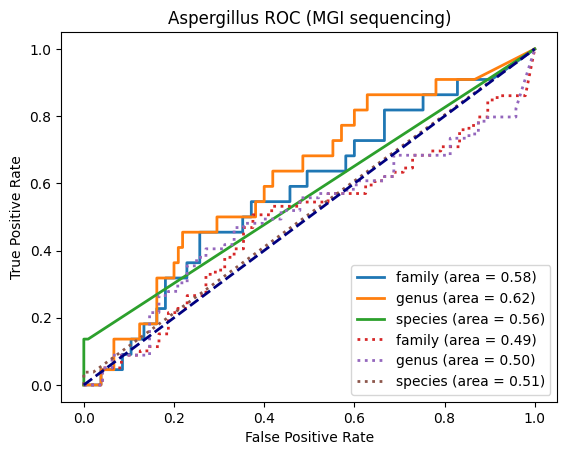

In [13]:
sequence_type = "MGI"
sslevel = 'subsystems_norm_ss.tsv.gz'

aspname = {'family': 'Aspergillaceae', 'genus': 'Aspergillus', 'species': 'Aspergillus campestris'}
#aspname = {'genus': 'Aspergillus', 'family': 'Aspergillaceae'}

plt.figure()

for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + ['CS_Aspergillus fumigatus']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res['CS_Aspergillus fumigatus']
    y_scores = res[aspname[taxa]]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{taxa} (area = {roc_auc:.2f})')

for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + ['CS_Aspergillus fumigatus', 'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res[['CS_Aspergillus fumigatus',  'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']].astype(bool).any(axis=1)
    y_scores = res[aspname[taxa]]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, linestyle=':', label=f'{taxa} (area = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Aspergillus ROC ({sequence_type} sequencing)')
plt.legend(loc="lower right")
plt.show()

# Violin plots for Aspergillus abundance

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


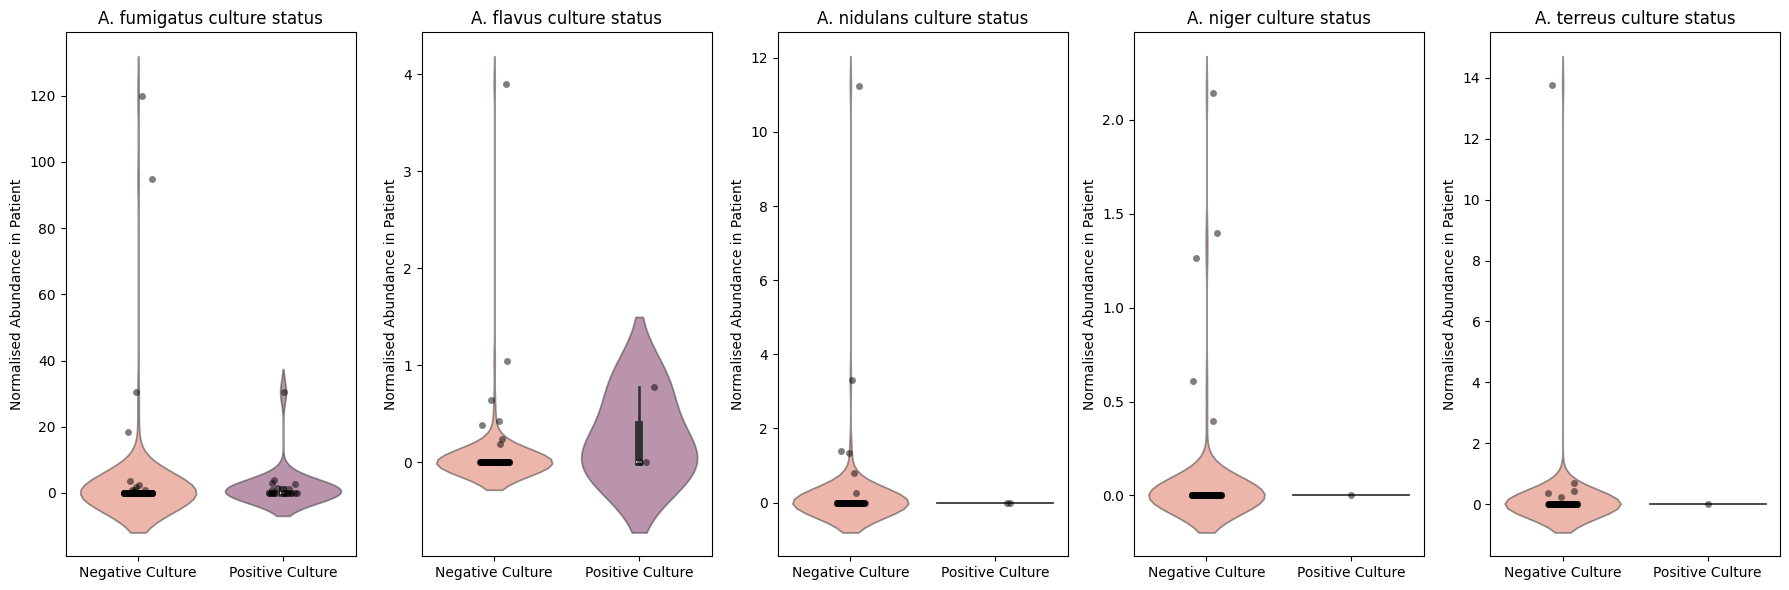

In [15]:

taxa = 'species'
cs = {
    'CS_Aspergillus fumigatus': 'Aspergillus fumigatus',  
    'CS_Aspergillus flavus': 'Aspergillus flavus',  
    'CS_Aspergillus nidulans': 'Aspergillus nidulans',  
    'CS_Aspergillus niger': 'Aspergillus niger',  
    'CS_Aspergillus terreus': 'Aspergillus terreus'
}

cults = cs.keys()
taxas = cs.values()

fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=len(cs), sharex=False, sharey=False)
j = 0
sequence_type = 'MGI'
df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
merged = df[taxas].join(metadata[cults], how='inner')

for i, c in enumerate(cs.keys()):
    subset_data = merged[merged[c].notna()]
    g = sns.violinplot(x=c, y=cs[c], data=subset_data, hue=c, palette='rocket_r', alpha=0.5, ax=ax[i], legend=False)
    g = sns.stripplot(x=c, y=cs[c], data=subset_data, color='black', jitter=True, alpha=0.5, ax=ax[i], legend=False)
    g.set_xlabel("")
    g.set_ylabel("Normalised Abundance in Patient")
    g.set_xlim(-0.5, 1.5)
    g.set_xticks(ticks=[0, 1], labels=["Negative Culture", "Positive Culture"])
    g.set_title(f"{c.replace('CS_', '').replace('Aspergillus', 'A.')} culture status")


plt.tight_layout()
plt.show()

# IgE and Precipitins

In [18]:
igs = ['IgE', 'Spec IgE', 'Spec IgG', 'Precipitins']
intcols = igs+['CS_Aspergillus fumigatus', 'CS_Aspergillus flavus', 'CS_Aspergillus nidulans', 'CS_Aspergillus niger', 'CS_Aspergillus terreus'] 
fungim = metadata[intcols].dropna(how='all', subset=igs)
fungim.sort_values(by='Precipitins')

,IgE,Spec IgE,Spec IgG,Precipitins,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus
NAME,,,,,,,,,
1447437_20171212_S,3.0,0.00,NaN,0.0,0,0,0,0,0
773911_20180130_S,296.0,1.20,NaN,0.0,0,0,0,0,0
770590_20170925_S,33.0,0.00,NaN,0.0,0,0,0,0,0
770560_20181218_S,76.0,0.00,60.0,0.0,0,0,0,0,0
768745_20171123_S,48.0,0.00,NaN,0.0,0,0,0,0,0
763742_20180129_S,5.0,0.00,NaN,0.0,0,0,0,0,0
763742_20170925_S,3.0,0.00,NaN,0.0,0,0,0,0,0
756934_20181205_S,162.0,0.00,5.0,0.0,0,0,0,0,0
753522_20180606_S,257.0,2.07,11.0,0.0,0,0,0,0,0


# ABPA Classification

Feature	| Threshold(s) | Rationale | Source
--- | --- | --- | ---
IgE (total)	| ≥500 | possible ABPA 	| CF Foundation & ISHAM criteria.
|| ≥1000 | probable/strong ABPA
Spec IgE | ≥0.35 | sensitised | ImmunoCAP grading (0.35–100 kUA/L).
|| ≥1.0 | strong sensitisation
|| ≥10 | very strong ABPA-associated sensitisation 
Spec IgG | >40 | exposed or colonised | Typical cut-offs in CF diagnostic panels.
|| ≥100 | chronic colonisation or ABPA
Precipitins | 0 | negative | Semiquantitative serology grading.
|| 1 | weak positive (exposure)
|| 2 | strong positive (active immune response)


Category | Criteria| Meaning
--- | --- | ---
0 – No sensitisation | IgE < 100 and Spec_IgE < 0.35 and Spec_IgG ≤ 40 and Precipitins == 0 | No evidence of fungal exposure.
1 – Sensitised | 100 ≤ IgE < 500 or Spec_IgE ≥ 0.35 | Sensitised but no allergic disease.
2 – Possible ABPA | (IgE ≥ 500 and Spec_IgE ≥ 1.0) or (Spec_IgG ≥ 100) or (Precipitins ≥ 1) | Immune response consistent with ABPA; needs confirmation.
3 – Probable ABPA | (IgE ≥ 1000 and Spec_IgE ≥ 10) or (Precipitins == 2) | Meets serologic thresholds for ABPA; likely disease.

In [24]:
def classify_abpa(row):
    IgE = row['IgE']
    Spec_IgE = row['Spec IgE']
    Spec_IgG = row['Spec IgG']
    Precipitins = row['Precipitins']

    if IgE >= 1000 and Spec_IgE >= 10 or Precipitins == 2:
        return 3  # Probable ABPA
    elif IgE >= 500 and Spec_IgE >= 1 or Spec_IgG >= 100 or Precipitins >= 1:
        return 2  # Possible ABPA
    elif IgE >= 100 or Spec_IgE >= 0.35:
        return 1  # Sensitised
    else:
        return 0  # No sensitisation

metadata['ABPA_status'] = metadata.apply(classify_abpa, axis=1).astype('category')
intcols = igs + ['CS_Aspergillus fumigatus', 'CS_Aspergillus flavus', 'CS_Aspergillus nidulans', 'CS_Aspergillus niger', 'CS_Aspergillus terreus'] + ['ABPA_status']
metadata[intcols].sort_values(by='ABPA_status', ascending=False)

,IgE,Spec IgE,Spec IgG,Precipitins,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus,ABPA_status
NAME,,,,,,,,,,
983493_20180123_S,12.0,0.92,NaN,2.0,0,0,0,0,0,3
634207_20180510_S,1750.0,31.00,122.0,1.0,0,1,0,0,0,3
748699_20190114_S,8.0,0.00,69.0,2.0,0,0,0,0,0,3
748699_20190101_S,6.0,0.00,63.0,2.0,1,0,0,0,0,3
698917_20180119_S,67.0,0.71,NaN,2.0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
658355_20180122_S,NaN,NaN,NaN,NaN,0,0,0,0,0,0
658355_20170925_S,NaN,NaN,NaN,NaN,0,0,0,0,0,0
650003_20180213_S,NaN,NaN,NaN,NaN,1,0,0,0,0,0


In [25]:
metadata.dtypes

minion                                             object
MGI                                                object
pwCF_ID                                             int64
Sample date                                datetime64[ns]
IP vs OP                                         category
                                                ...      
Index I7                                           object
Index I5                                           object
Mean_Size_BP                                        int64
Total Clusters Passing Filter (Million)           float64
ABPA_status                                      category
Length: 167, dtype: object